Loading the mask and without mask data and apply ML

In [2]:
import numpy as np
import cv2

In [3]:
with_mask=np.load('with_mask.npy')
without_mask=np.load('without_mask.npy')
#no_person= np.load('No_Person.npy')

In [5]:
with_mask

array([[[[ 76,  50,  35],
         [ 87,  48,  50],
         [ 81,  52,  50],
         ...,
         [ 95,  46,  42],
         [ 58,  47,  41],
         [ 67,  46,  44]],

        [[ 97,  45,  35],
         [ 76,  51,  28],
         [ 91,  54,  31],
         ...,
         [ 83,  54,  28],
         [ 74,  50,  45],
         [ 76,  52,  26]],

        [[ 78,  52,  60],
         [ 94,  55,  42],
         [ 75,  55,  51],
         ...,
         [ 87,  50,  31],
         [ 77,  56,  33],
         [ 65,  52,  52]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [108, 122, 138],
         [103,  92,  80],
         [ 94,  90,  90]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [112, 133, 147],
         [111, 100,  95],
         [120,  88, 100]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [111, 104, 130],
        

In [113]:
without_mask.shape

(400, 50, 50, 3)

In [114]:
#no_person.shape

In [115]:
with_mask=with_mask.reshape(400,50*50*3)
without_mask=without_mask.reshape(400,50*50*3)
#no_person = no_person.reshape(400,50*50*3)

And we will concatenate the data into a single array :

In [116]:
X=np.r_[with_mask,without_mask] #row binding
X.shape

(800, 7500)

Creating target variables

In [117]:
labels = np.zeros(X.shape[0]) #800 zeros 

In [118]:
labels[400:]=1.0 #with_mask
#labels[401:800] = 0.0 #no_mask
#labels[:1200]=2 #no person

In [119]:
mask_dict = {0: 'Wearing Mask', 1: 'No Mask Detected'}

Applying ml model

In [120]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [128]:
x_train,x_test,y_train,y_test=train_test_split(X,labels,test_size=0.20)

In [122]:
x_train.shape

(640, 7500)

In [123]:
x_test.shape

(160, 7500)

In [71]:
from sklearn.decomposition import PCA

In [133]:
#pca=PCA(n_components=5)
#x_train=pca.fit_transform(x_train)


In [134]:
x_train[0] #reduced to 5

array([-4792.4503996 ,   117.75939372,  -284.8319483 ,  -918.41575412,
          93.86441096])

In [124]:
x_train,x_test,y_train,y_test=train_test_split(X,labels,test_size=0.35)

In [135]:
svm=SVC()
svm.fit(x_train,y_train)


SVC()

In [138]:
#x_test=pca.transform(x_test)

In [139]:

y_pred = svm.predict(x_test)

In [140]:
accuracy_score(y_test,y_pred)

0.98125

So finally, we can test our faces with or without mask and check whether this algorithm is able to identity you that you are wearing a mask or not.

In [81]:
haar_data = cv2.CascadeClassifier('data.xml')
capture = cv2.VideoCapture(0)
font=cv2.FONT_HERSHEY_COMPLEX 

data=[] # to store face data
       
while True:
    flag,img = capture.read() #read 1frame at a time
    #print(img) #why is flag always true? ->maybe to check camera is working or not
    
    if flag:
        faces=haar_data.detectMultiScale(img) #loop will start here for multiple faces. if no face detected : "No Person Detected"
        # print(faces)  # ()-> when nothing detected. 4 X 1 arrays when visible
        for x,y,w,h in faces: 
            cv2.rectangle(img,(x,y),(x+w, y+h),(255,0,255),4) # not necessary here
            face=img[y:y+h,x:x+w,:] # selecting and storing face and compressing it to supply it to the model for prediction
            face=cv2.resize(face, (50,50)) 
            face=face.reshape(1,-1) # from here code for social distancing will come, and in that code the mask will be a subpart
            pred = svm.predict(face)[0] #prediction on facemask
            #print(pred) #1.0 when maskface detected, 0.0 when no facemask
            n=mask_dict[int(pred)] #int(pred) is the key to the dictionary
            if n=="No Mask Detected":
                cv2.putText(img,n,(x,y),font,1,(0,0,250),2)
            elif n=="Wearing Mask": 
                cv2.putText(img,n,(x,y),font,1,(0,255,0),2)
#             else:
#                 cv2.rectangle(img,(x,y),(x+w, y+h),(255,255,0),4)
#                 cv2.putText(img,"No Person in Frame",(x,y),font,1,(255,255,0),2)
#             print(n)
    cv2.imshow('result',img)
    
    if cv2.waitKey(2)==27:
        break
capture.release()
cv2.destroyAllWindows()

# Detecting social distancing violations
This can be done by iterating over the coordinates of faces and calculating the distance for each possible pair, if the distance for a particular pair is less than MIN_DISTANCE then the bounding boxes for those faces are colored red. MIN_DISTANCE must be manually initialized in such a way that it corresponds to the minimum allowable distance in real life (ex. 6ft in India).

In [40]:
MIN_DISTANCE = 850

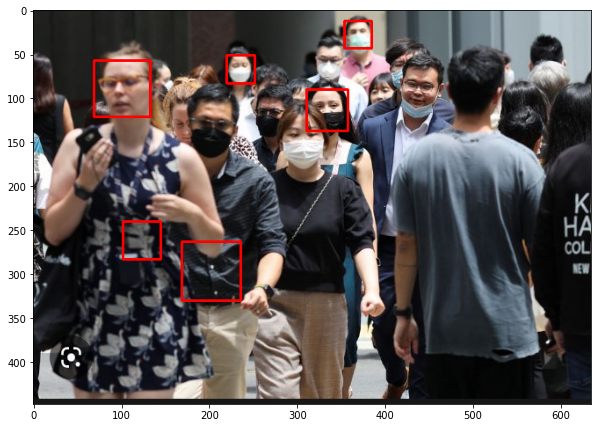

In [66]:
from scipy.spatial import distance
import matplotlib.pyplot as plt

img=cv2.imread("D:\\Coding_Projects\\Face-Mask-Detection\\people.JPG")
haar_data = cv2.CascadeClassifier('data.xml')
faces=haar_data.detectMultiScale(img)
if len(faces)>=2: # inside flag if
    label = [0 for i in range(len(faces))] #creating 0's for the number of faces detected
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            #print(dist)
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1 #below here mask code
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),2)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(img,"brrr",(x,y),font,1,(0,0,250),2)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else: # here also put mask code
    print("No. of faces detected is less than 2")

Integrating both

In [141]:
mask_dict = {0:'No Mask Detected',1:'Wearing Mask'}
dist_dict = {0:(0,255,0),1:(255,0,0)}


MIN_DISTANCE = 850

In [142]:
from scipy.spatial import distance
import matplotlib.pyplot as plt


haar_data = cv2.CascadeClassifier('data.xml')
capture = cv2.VideoCapture(0)
font=cv2.FONT_HERSHEY_COMPLEX 

data=[] # to store face data
       
while True:
    flag,img = capture.read() #read 1frame at a time
    #print(img) #why is flag always true? ->maybe to check camera is working or not
    if flag:
        faces=haar_data.detectMultiScale(img) #loop will start here for multiple faces. if no face detected : "No Person Detected"
        # print(faces)  # ()-> when nothing detected. 4 X 1 arrays when visible
#         if len(faces)==0:
#             for x,y,w,h in faces:
#                 cv2.putText(img,'NO PERSON DETECTED',(x,y),font,1,(0,0,250),2)
            
        if len(faces)>=2: # inside flag if
            print("More than 2 faces detected")
            label = [0 for i in range(len(faces))] #creating 0's for the number of faces detected
            for i in range(len(faces)-1):
                for j in range(i+1, len(faces)):
                    dist = distance.euclidean(faces[i][:2],faces[j][:2])
                    #print(dist)
                    if dist<MIN_DISTANCE:
                        label[i] = 1
                        label[j] = 1 #below here mask code
            #new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
            for i in range(len(faces)):
                
                for x,y,w,h in faces: 
                    #cv2.rectangle(img,(x,y),(x+w, y+h),(255,0,255),4) # not necessary here
                    face=img[y:y+h,x:x+w,:] # selecting and storing face and compressing it to supply it to the model for prediction
                    face=cv2.resize(face, (50,50)) 
                    face=face.reshape(1,-1) # from here code for social distancing will come, and in that code the mask will be a subpart
                    pred = svm.predict(face)[0] #prediction on facemask
                    #print(pred) #1.0 when maskface detected, 0.0 when no facemask
                    n=mask_dict[int(pred)] #int(pred) is the key to the dictionary
                    
                    if label[i]==1: #social distancing maintained
                        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),4)
                        if n=="No Mask Detected":
                            cv2.putText(img," Not Wearing mask",(x,y),font,1,(0,0,255),2)
                        elif n=="Wearing Mask": 
                            cv2.putText(img,"Wearing Mask",(x,y),font,1,(0,255,0),2)
                    
                    else:
                        print("WARNING: SOCIAL DISTANCING NOT MAINTAINED")
                        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),4)
                        if n=="No Mask Detected":
                            cv2.putText(img,n,(x,y),font,1,(0,0,250),2)
                        elif n=="Wearing Mask": 
                            cv2.putText(img,n,(x,y),font,1,(0,255,0),2)
                cv2.imshow('result',img)    
        else:
            print("No. of faces detected is 1")
            
            for x,y,w,h in faces: 
                cv2.rectangle(img,(x,y),(x+w, y+h),(0,255,0),4) # not necessary here
                face=img[y:y+h,x:x+w,:] # selecting and storing face and compressing it to supply it to the model for prediction
                face=cv2.resize(face, (50,50)) 
                face=face.reshape(1,-1) # from here code for social distancing will come, and in that code the mask will be a subpart
                pred = svm.predict(face)[0] #prediction on facemask
                #print(pred) #1.0 when maskface detected, 0.0 when no facemask
                n=mask_dict[int(pred)] #int(pred) is the key to the dictionary
                if n=="No Mask Detected":
                    cv2.putText(img,"Wearing mask",(x,y),font,1,(0,255,0),2)
                elif n=="Wearing Mask": 
                    cv2.putText(img,"Not Wearing Mask",(x,y),font,1,(0,0,255),2)
#             else:
#                 cv2.rectangle(img,(x,y),(x+w, y+h),(255,255,0),4)
#                 cv2.putText(img,"No Person in Frame",(x,y),font,1,(255,255,0),2)
#             print(n)
        cv2.imshow('result',img)
    if cv2.waitKey(2)==27:
        break
capture.release()
cv2.destroyAllWindows()

No. of faces detected is 1


ValueError: X has 7500 features, but SVC is expecting 5 features as input.